<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/gpytorch_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression using GPyTorch

## Dependencies

In [3]:
!pip install gpytorch

Function to model:

\begin{align}
y &= \sin(2\pi x) + \epsilon \;\; (1)\\
  \epsilon &\sim \mathcal{N}(0, 0.2) \;\; (2) 
\end{align}

with 100 training examples, and testing on 51 examples.

In [0]:
import math
import torch
import os
import matplotlib.pyplot as plt

from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel
from gpytorch.kernels import RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.settings import fast_pred_var

## Setup training data

In [0]:
# training data is 100 points in [0,1] regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is (1) with Gaussian noise (2)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size())

## Setting up the model

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A **GP Model** (`gpytorch.models.ExactGP`) -  This handles most of the inference.
1. A **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - This is the most common likelihood used for GP regression.
1. A **Mean** - This defines the prior mean of the GP.(If you don't know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.)
1. A **Kernel** - This defines the prior covariance of the GP.(If you don't know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start).
1. A **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.

### The GP Model
  
The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

1. An `__init__` method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model's `forward` method. This will most commonly include things like a mean module and a kernel module.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a `MultivariateNormal` with the *prior* mean and covariance evaluated at `x`. In other words, we return the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP. 

This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

```python
self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())
```

Or you can add the outputs of the kernel in the forward method:

```python
covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)
```


In [0]:
class ExactGPModel(ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = ConstantMean()
    self.covar_module = ScaleKernel(RBFKernel())

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return MultivariateNormal(mean_x, covar_x)

# initialize likelyhood and model
likelihood = GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Training the model

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).


In [24]:
training_iter = 50
# fin optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
  {'params': model.parameters()}
], lr=0.1)

# loss for gps - the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y)
  loss.backward()
  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
  ))
  optimizer.step()


Iter 1/50 - Loss: 1.570   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.549   lengthscale: 0.644   noise: 0.744
Iter 3/50 - Loss: 1.531   lengthscale: 0.598   noise: 0.798
Iter 4/50 - Loss: 1.518   lengthscale: 0.554   noise: 0.852
Iter 5/50 - Loss: 1.508   lengthscale: 0.513   noise: 0.906
Iter 6/50 - Loss: 1.501   lengthscale: 0.474   noise: 0.959
Iter 7/50 - Loss: 1.495   lengthscale: 0.437   noise: 1.010
Iter 8/50 - Loss: 1.492   lengthscale: 0.403   noise: 1.058
Iter 9/50 - Loss: 1.489   lengthscale: 0.370   noise: 1.102
Iter 10/50 - Loss: 1.488   lengthscale: 0.341   noise: 1.140
Iter 11/50 - Loss: 1.487   lengthscale: 0.313   noise: 1.173
Iter 12/50 - Loss: 1.487   lengthscale: 0.288   noise: 1.200
Iter 13/50 - Loss: 1.486   lengthscale: 0.266   noise: 1.220
Iter 14/50 - Loss: 1.486   lengthscale: 0.246   noise: 1.234
Iter 15/50 - Loss: 1.486   lengthscale: 0.228   noise: 1.242
Iter 16/50 - Loss: 1.486   lengthscale: 0.213   noise: 1.245
Iter 17/50 - Loss: 1.485   length

# Make predictions with the model

Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

In [0]:
# f_preds = model(test_x)
# y_preds = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_sample = f_preds.sample(sample_shape=torch.Size(1000,))

# get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# test points are regularly spaces along [0,1]
# make predictions by feeding model through likelihood
with torch.no_grad(), fast_pred_var():
  test_x = torch.linspace(0, 1, 51)
  observed_pred = likelihood(model(test_x))


### Plot the model

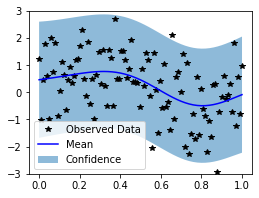

In [32]:
with torch.no_grad():
  f, ax = plt.subplots(1, 1, figsize=(4, 3))
  lower, upper = observed_pred.confidence_region()
  ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
  ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
  ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
